## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [44]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [45]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('data/dog_images/train')
valid_files, valid_targets = load_dataset('data/dog_images/valid')
test_files, test_targets = load_dataset('data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [46]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


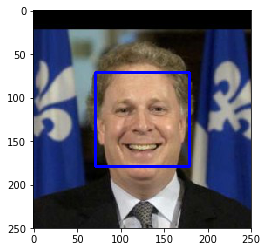

In [47]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[6])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)


# print number of faces detected in the image
print('Number of faces detected:', len(faces))


# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

- What percentage of the first 100 images in `human_files` have a detected human face?   100%
- What percentage of the first 100 images in `dog_files` have a detected human face? 11%

In [6]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_files_short_results = np.array(list(map(face_detector, human_files_short)))
dog_files_short_results = np.array(list(map(face_detector, dog_files_short)))

print(np.count_nonzero(human_files_short_results) / human_files_short.size)
print(np.count_nonzero(dog_files_short_results) / dog_files_short.size)


0.99
0.12


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

No, as this restriction may impact the user experience itself. I would suggest doing image augmentation as to reduce the overfitting of the human face detector and thus allowing it to be able to work with more general images that may not all be face-on, etc.

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [7]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [8]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [9]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    print('calling path to tensor to load image to array')
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [136]:

def ResNet50_predict_labels(img_path):
    from keras.applications.resnet50 import preprocess_input, decode_predictions
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

- What percentage of the images in `human_files_short` have a detected dog? __0%__
- What percentage of the images in `dog_files_short` have a detected dog? __100%__

In [12]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_files_short_resnet_results = [dog_detector(img_path) for img_path in human_files_short]
dog_files_short_resnet_results = [dog_detector(img_path) for img_path in dog_files_short]

print(np.count_nonzero(human_files_short_resnet_results) / human_files_short.size)
print(np.count_nonzero(dog_files_short_resnet_results) / dog_files_short.size)

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
0.0
1.0


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [158]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255


  0%|          | 22/6680 [00:00<00:32, 207.43it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

  1%|          | 52/6680 [00:00<00:45, 144.40it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

  1%|          | 82/6680 [00:00<00:46, 143.06it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

  2%|▏         | 114/6680 [00:00<00:46, 140.21it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

  2%|▏         | 130/6680 [00:00<00:45, 144.19it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


  2%|▏         | 145/6680 [00:01<01:09, 93.79it/s] 

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


  3%|▎         | 177/6680 [00:01<01:02, 104.26it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

  3%|▎         | 215/6680 [00:01<00:49, 130.55it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

  3%|▎         | 231/6680 [00:01<00:50, 127.92it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

  4%|▍         | 265/6680 [00:02<00:47, 134.74it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

  4%|▍         | 280/6680 [00:02<00:58, 109.02it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

  5%|▍         | 311/6680 [00:02<00:56, 113.15it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

  5%|▌         | 352/6680 [00:02<00:44, 143.32it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

  6%|▌         | 369/6680 [00:02<00:58, 108.21it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


  6%|▌         | 383/6680 [00:03<01:01, 102.28it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


  6%|▌         | 407/6680 [00:03<01:07, 92.55it/s] 

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

  7%|▋         | 440/6680 [00:03<00:53, 116.63it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

  7%|▋         | 466/6680 [00:03<01:09, 89.91it/s] 

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


  7%|▋         | 482/6680 [00:04<01:00, 102.65it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


  8%|▊         | 512/6680 [00:04<01:08, 90.47it/s] 

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

  8%|▊         | 542/6680 [00:04<00:54, 113.23it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

  8%|▊         | 556/6680 [00:04<01:03, 96.47it/s] 

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

  9%|▉         | 586/6680 [00:05<01:03, 95.82it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

  9%|▉         | 621/6680 [00:05<00:49, 121.71it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 10%|▉         | 635/6680 [00:05<00:48, 123.56it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 10%|▉         | 667/6680 [00:05<00:48, 123.61it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 11%|█         | 702/6680 [00:05<00:42, 142.28it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 11%|█         | 739/6680 [00:06<00:45, 129.86it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 12%|█▏        | 773/6680 [00:06<00:44, 133.78it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 12%|█▏        | 795/6680 [00:06<00:38, 151.47it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 12%|█▏        | 827/6680 [00:06<00:46, 125.42it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 13%|█▎        | 859/6680 [00:07<00:41, 139.63it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 13%|█▎        | 893/6680 [00:07<00:42, 137.66it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 14%|█▍        | 922/6680 [00:07<01:00, 95.56it/s] 

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 14%|█▍        | 956/6680 [00:07<00:48, 118.71it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 15%|█▍        | 988/6680 [00:08<00:55, 101.91it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 15%|█▌        | 1006/6680 [00:08<00:49, 113.96it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 15%|█▌        | 1020/6680 [00:08<01:05, 87.01it/s] 

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 16%|█▌        | 1056/6680 [00:09<00:53, 105.46it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 16%|█▌        | 1084/6680 [00:09<00:47, 118.49it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 17%|█▋        | 1116/6680 [00:09<00:46, 120.77it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 17%|█▋        | 1149/6680 [00:09<00:56, 97.40it/s] 

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 17%|█▋        | 1162/6680 [00:10<00:58, 93.65it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 18%|█▊        | 1193/6680 [00:10<00:51, 107.24it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 18%|█▊        | 1207/6680 [00:10<00:47, 114.96it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 18%|█▊        | 1234/6680 [00:10<00:51, 106.75it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 19%|█▉        | 1262/6680 [00:10<00:50, 108.15it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 19%|█▉        | 1297/6680 [00:11<00:40, 132.77it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 20%|█▉        | 1320/6680 [00:11<00:35, 151.54it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 20%|██        | 1338/6680 [00:11<00:47, 111.72it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 20%|██        | 1367/6680 [00:11<00:48, 108.55it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 21%|██        | 1386/6680 [00:11<00:42, 124.30it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 21%|██        | 1414/6680 [00:12<00:49, 105.91it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 22%|██▏       | 1445/6680 [00:12<00:42, 123.31it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 22%|██▏       | 1459/6680 [00:12<00:49, 104.43it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 22%|██▏       | 1498/6680 [00:12<00:38, 134.46it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 23%|██▎       | 1531/6680 [00:12<00:35, 145.13it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 23%|██▎       | 1547/6680 [00:13<00:36, 140.67it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 24%|██▎       | 1576/6680 [00:13<00:47, 107.27it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 24%|██▍       | 1590/6680 [00:13<00:50, 101.43it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 24%|██▍       | 1604/6680 [00:13<00:46, 108.91it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 24%|██▍       | 1633/6680 [00:13<00:45, 112.06it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 25%|██▍       | 1668/6680 [00:14<00:36, 135.64it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 26%|██▌       | 1705/6680 [00:14<00:44, 112.52it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 26%|██▌       | 1724/6680 [00:14<00:39, 126.68it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 26%|██▋       | 1758/6680 [00:14<00:38, 127.63it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 27%|██▋       | 1789/6680 [00:15<00:38, 127.17it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 27%|██▋       | 1812/6680 [00:15<00:33, 145.78it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 28%|██▊       | 1844/6680 [00:15<00:37, 128.11it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 28%|██▊       | 1873/6680 [00:15<00:38, 123.26it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 29%|██▊       | 1906/6680 [00:16<00:41, 115.02it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 29%|██▉       | 1927/6680 [00:16<00:35, 132.08it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 29%|██▉       | 1962/6680 [00:16<00:34, 137.27it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 30%|██▉       | 2000/6680 [00:16<00:29, 157.85it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 30%|███       | 2032/6680 [00:17<01:01, 75.85it/s] 

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 31%|███       | 2060/6680 [00:17<00:49, 92.62it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 31%|███▏      | 2093/6680 [00:17<00:40, 113.38it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 32%|███▏      | 2130/6680 [00:18<00:34, 130.39it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 32%|███▏      | 2149/6680 [00:18<00:34, 130.77it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 33%|███▎      | 2183/6680 [00:18<00:33, 134.15it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 33%|███▎      | 2198/6680 [00:18<00:33, 132.88it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 33%|███▎      | 2231/6680 [00:18<00:32, 135.10it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 34%|███▎      | 2254/6680 [00:18<00:28, 153.51it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 34%|███▍      | 2289/6680 [00:19<00:41, 105.56it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 34%|███▍      | 2304/6680 [00:19<00:39, 110.41it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 35%|███▍      | 2333/6680 [00:19<00:40, 107.38it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 35%|███▌      | 2346/6680 [00:19<00:47, 91.36it/s] 

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 35%|███▌      | 2357/6680 [00:20<00:54, 78.68it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 36%|███▌      | 2384/6680 [00:20<00:47, 91.40it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 36%|███▋      | 2422/6680 [00:20<00:38, 111.40it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 37%|███▋      | 2454/6680 [00:20<00:35, 117.73it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 37%|███▋      | 2489/6680 [00:21<00:34, 122.76it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 38%|███▊      | 2525/6680 [00:21<00:30, 138.34it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 38%|███▊      | 2541/6680 [00:21<00:29, 138.43it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 38%|███▊      | 2570/6680 [00:21<00:32, 125.46it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 39%|███▉      | 2600/6680 [00:21<00:30, 132.54it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 39%|███▉      | 2628/6680 [00:22<00:33, 119.56it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 40%|███▉      | 2658/6680 [00:22<00:33, 121.52it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 40%|███▉      | 2671/6680 [00:22<00:35, 113.10it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 40%|████      | 2685/6680 [00:22<00:33, 119.97it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 41%|████      | 2722/6680 [00:23<00:32, 120.86it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 41%|████▏     | 2763/6680 [00:23<00:25, 150.74it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 42%|████▏     | 2780/6680 [00:23<00:30, 128.73it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 42%|████▏     | 2808/6680 [00:23<00:43, 88.90it/s] 

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 43%|████▎     | 2841/6680 [00:24<00:33, 115.03it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 43%|████▎     | 2856/6680 [00:24<00:34, 110.93it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 43%|████▎     | 2884/6680 [00:24<00:37, 100.01it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 44%|████▎     | 2909/6680 [00:24<00:42, 89.43it/s] 

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 44%|████▍     | 2945/6680 [00:25<00:31, 120.24it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 45%|████▍     | 2976/6680 [00:25<00:28, 131.59it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 45%|████▍     | 3005/6680 [00:25<00:28, 129.80it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 45%|████▌     | 3038/6680 [00:25<00:25, 144.72it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 46%|████▌     | 3055/6680 [00:25<00:24, 149.37it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 46%|████▌     | 3085/6680 [00:26<00:32, 112.32it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 46%|████▋     | 3098/6680 [00:26<00:35, 100.96it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 47%|████▋     | 3119/6680 [00:26<00:44, 79.76it/s] 

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 47%|████▋     | 3149/6680 [00:26<00:34, 102.52it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 47%|████▋     | 3161/6680 [00:27<00:39, 89.22it/s] 

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 48%|████▊     | 3184/6680 [00:27<00:38, 91.26it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 48%|████▊     | 3204/6680 [00:27<00:38, 90.87it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 48%|████▊     | 3219/6680 [00:27<00:33, 103.05it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 49%|████▊     | 3247/6680 [00:27<00:39, 87.72it/s] 

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 49%|████▉     | 3258/6680 [00:28<00:36, 93.23it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 49%|████▉     | 3283/6680 [00:28<00:37, 90.94it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 50%|████▉     | 3312/6680 [00:28<00:29, 112.37it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 50%|████▉     | 3338/6680 [00:28<00:34, 95.54it/s] 

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 50%|█████     | 3357/6680 [00:28<00:29, 111.85it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 51%|█████     | 3390/6680 [00:29<00:25, 130.76it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 51%|█████     | 3421/6680 [00:29<00:29, 111.49it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 52%|█████▏    | 3454/6680 [00:29<00:27, 116.00it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 52%|█████▏    | 3470/6680 [00:29<00:25, 125.80it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 52%|█████▏    | 3505/6680 [00:30<00:22, 140.93it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 53%|█████▎    | 3520/6680 [00:30<00:24, 128.67it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 53%|█████▎    | 3549/6680 [00:30<00:27, 112.52it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 54%|█████▎    | 3590/6680 [00:30<00:21, 144.57it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 54%|█████▍    | 3629/6680 [00:30<00:19, 159.22it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 55%|█████▍    | 3667/6680 [00:31<00:18, 166.95it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 55%|█████▌    | 3685/6680 [00:31<00:20, 143.56it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 56%|█████▌    | 3716/6680 [00:31<00:23, 124.60it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 56%|█████▌    | 3755/6680 [00:31<00:20, 141.96it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 56%|█████▋    | 3771/6680 [00:31<00:24, 120.16it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 57%|█████▋    | 3803/6680 [00:32<00:22, 126.29it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 57%|█████▋    | 3830/6680 [00:32<00:25, 110.85it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 58%|█████▊    | 3853/6680 [00:32<00:21, 129.13it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 58%|█████▊    | 3882/6680 [00:32<00:22, 122.27it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 58%|█████▊    | 3900/6680 [00:32<00:20, 133.31it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 59%|█████▊    | 3915/6680 [00:33<00:33, 81.82it/s] 

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 59%|█████▉    | 3939/6680 [00:33<00:33, 81.77it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 60%|█████▉    | 3976/6680 [00:33<00:24, 108.75it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 60%|█████▉    | 4006/6680 [00:34<00:21, 124.64it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 61%|██████    | 4043/6680 [00:34<00:18, 143.66it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 61%|██████    | 4076/6680 [00:34<00:17, 148.55it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 61%|██████▏   | 4092/6680 [00:34<00:22, 115.93it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 62%|██████▏   | 4111/6680 [00:34<00:19, 130.19it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 62%|██████▏   | 4140/6680 [00:35<00:22, 115.05it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 62%|██████▏   | 4168/6680 [00:35<00:22, 111.59it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 63%|██████▎   | 4180/6680 [00:35<00:23, 107.21it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 63%|██████▎   | 4194/6680 [00:35<00:21, 113.96it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 63%|██████▎   | 4225/6680 [00:35<00:24, 101.40it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 64%|██████▎   | 4242/6680 [00:35<00:22, 110.41it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 64%|██████▍   | 4276/6680 [00:36<00:21, 109.57it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 64%|██████▍   | 4293/6680 [00:36<00:19, 121.47it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 65%|██████▍   | 4325/6680 [00:36<00:19, 122.89it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 65%|██████▌   | 4360/6680 [00:36<00:20, 113.06it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 65%|██████▌   | 4374/6680 [00:37<00:22, 104.79it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 66%|██████▌   | 4391/6680 [00:37<00:19, 118.16it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 66%|██████▌   | 4421/6680 [00:37<00:21, 106.47it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 67%|██████▋   | 4457/6680 [00:37<00:16, 131.52it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 67%|██████▋   | 4489/6680 [00:38<00:18, 117.72it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 67%|██████▋   | 4503/6680 [00:38<00:18, 116.04it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 68%|██████▊   | 4519/6680 [00:38<00:19, 109.70it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 68%|██████▊   | 4544/6680 [00:38<00:27, 79.02it/s] 

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 69%|██████▊   | 4582/6680 [00:38<00:19, 110.20it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 69%|██████▉   | 4597/6680 [00:39<00:17, 117.67it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 69%|██████▉   | 4631/6680 [00:39<00:16, 127.87it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 70%|██████▉   | 4663/6680 [00:39<00:14, 135.33it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 70%|███████   | 4678/6680 [00:39<00:17, 116.15it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 70%|███████   | 4705/6680 [00:39<00:17, 113.40it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 71%|███████   | 4750/6680 [00:40<00:12, 149.51it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 72%|███████▏  | 4788/6680 [00:40<00:13, 139.01it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 72%|███████▏  | 4805/6680 [00:40<00:13, 141.20it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 72%|███████▏  | 4837/6680 [00:40<00:13, 132.61it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 73%|███████▎  | 4855/6680 [00:40<00:12, 142.73it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 73%|███████▎  | 4886/6680 [00:41<00:15, 112.65it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 74%|███████▎  | 4921/6680 [00:41<00:12, 136.56it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 74%|███████▍  | 4954/6680 [00:41<00:11, 146.42it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 75%|███████▍  | 4987/6680 [00:41<00:11, 148.92it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 75%|███████▌  | 5025/6680 [00:42<00:10, 163.56it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 75%|███████▌  | 5042/6680 [00:42<00:10, 157.42it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 76%|███████▌  | 5078/6680 [00:42<00:09, 161.27it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 76%|███████▋  | 5095/6680 [00:42<00:13, 115.50it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 77%|███████▋  | 5125/6680 [00:43<00:19, 80.40it/s] 

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 77%|███████▋  | 5161/6680 [00:43<00:13, 111.63it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 77%|███████▋  | 5175/6680 [00:43<00:14, 107.10it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 78%|███████▊  | 5209/6680 [00:43<00:11, 128.09it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 78%|███████▊  | 5242/6680 [00:43<00:10, 142.58it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 79%|███████▉  | 5275/6680 [00:44<00:09, 141.36it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 79%|███████▉  | 5294/6680 [00:44<00:09, 148.92it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 80%|███████▉  | 5324/6680 [00:44<00:11, 117.82it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 80%|████████  | 5357/6680 [00:44<00:11, 117.98it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 80%|████████  | 5377/6680 [00:45<00:09, 132.12it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 81%|████████  | 5392/6680 [00:45<00:11, 115.43it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 81%|████████▏ | 5429/6680 [00:45<00:09, 129.13it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 82%|████████▏ | 5462/6680 [00:45<00:09, 133.27it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 82%|████████▏ | 5502/6680 [00:45<00:07, 156.23it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 83%|████████▎ | 5539/6680 [00:46<00:07, 146.75it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 83%|████████▎ | 5577/6680 [00:46<00:06, 163.84it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 84%|████████▍ | 5609/6680 [00:46<00:10, 104.41it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 84%|████████▍ | 5638/6680 [00:47<00:09, 109.40it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 85%|████████▍ | 5651/6680 [00:47<00:10, 96.58it/s] 

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 85%|████████▌ | 5679/6680 [00:47<00:08, 113.46it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 85%|████████▌ | 5695/6680 [00:47<00:07, 123.68it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 86%|████████▌ | 5726/6680 [00:47<00:08, 111.08it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 86%|████████▌ | 5756/6680 [00:48<00:07, 124.24it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 87%|████████▋ | 5797/6680 [00:48<00:05, 153.18it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 87%|████████▋ | 5815/6680 [00:48<00:06, 136.25it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 88%|████████▊ | 5845/6680 [00:48<00:06, 119.59it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 88%|████████▊ | 5870/6680 [00:49<00:08, 96.89it/s] 

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 88%|████████▊ | 5905/6680 [00:49<00:06, 123.44it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 89%|████████▊ | 5921/6680 [00:49<00:05, 131.83it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 89%|████████▉ | 5954/6680 [00:49<00:05, 125.27it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 89%|████████▉ | 5974/6680 [00:49<00:05, 139.94it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 90%|████████▉ | 6010/6680 [00:50<00:05, 126.42it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 91%|█████████ | 6048/6680 [00:50<00:04, 151.30it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 91%|█████████ | 6081/6680 [00:50<00:04, 137.23it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 92%|█████████▏| 6118/6680 [00:50<00:03, 156.84it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 92%|█████████▏| 6135/6680 [00:50<00:03, 159.91it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 92%|█████████▏| 6167/6680 [00:51<00:04, 108.61it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 93%|█████████▎| 6198/6680 [00:51<00:03, 124.04it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 93%|█████████▎| 6212/6680 [00:51<00:04, 100.34it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 93%|█████████▎| 6224/6680 [00:51<00:04, 100.99it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 94%|█████████▎| 6256/6680 [00:52<00:03, 118.34it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 94%|█████████▍| 6276/6680 [00:52<00:03, 114.35it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 94%|█████████▍| 6308/6680 [00:52<00:03, 112.60it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 95%|█████████▍| 6337/6680 [00:52<00:02, 122.36it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 95%|█████████▌| 6367/6680 [00:52<00:02, 126.55it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 96%|█████████▌| 6381/6680 [00:53<00:03, 98.09it/s] 

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 96%|█████████▌| 6407/6680 [00:53<00:03, 84.78it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 96%|█████████▋| 6439/6680 [00:53<00:02, 92.20it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 97%|█████████▋| 6464/6680 [00:54<00:02, 103.00it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 97%|█████████▋| 6494/6680 [00:54<00:01, 112.18it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 97%|█████████▋| 6507/6680 [00:54<00:01, 89.50it/s] 

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 98%|█████████▊| 6518/6680 [00:54<00:01, 82.01it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 98%|█████████▊| 6542/6680 [00:55<00:01, 71.69it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 98%|█████████▊| 6568/6680 [00:55<00:01, 91.39it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 99%|█████████▉| 6603/6680 [00:55<00:00, 119.01it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 99%|█████████▉| 6617/6680 [00:55<00:00, 113.82it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

100%|█████████▉| 6652/6680 [00:55<00:00, 110.79it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

100%|█████████▉| 6667/6680 [00:56<00:00, 89.65it/s] 

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


100%|██████████| 6680/6680 [00:56<00:00, 118.39it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array



  0%|          | 3/835 [00:00<00:35, 23.32it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


  4%|▍         | 34/835 [00:00<00:19, 40.85it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

  8%|▊         | 67/835 [00:00<00:11, 65.67it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 11%|█▏        | 95/835 [00:00<00:08, 88.25it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 13%|█▎        | 108/835 [00:01<00:10, 72.54it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 14%|█▍        | 121/835 [00:01<00:10, 67.91it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 19%|█▊        | 155/835 [00:01<00:07, 94.31it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 22%|██▏       | 182/835 [00:01<00:05, 110.67it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 26%|██▌       | 213/835 [00:01<00:04, 129.32it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 27%|██▋       | 228/835 [00:01<00:04, 129.75it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 31%|███       | 260/835 [00:02<00:05, 114.67it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 36%|███▋      | 303/835 [00:02<00:03, 148.68it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 41%|████      | 339/835 [00:02<00:03, 160.40it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 45%|████▍     | 375/835 [00:02<00:02, 164.51it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 47%|████▋     | 393/835 [00:03<00:02, 166.48it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 52%|█████▏    | 432/835 [00:03<00:02, 157.06it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 56%|█████▌    | 467/835 [00:03<00:02, 162.17it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 60%|██████    | 503/835 [00:03<00:01, 166.73it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 64%|██████▍   | 535/835 [00:04<00:02, 111.55it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 69%|██████▊   | 574/835 [00:04<00:01, 137.92it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 73%|███████▎  | 606/835 [00:04<00:01, 144.09it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 77%|███████▋  | 639/835 [00:04<00:01, 141.52it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 78%|███████▊  | 654/835 [00:05<00:01, 99.31it/s] 

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 80%|███████▉  | 667/835 [00:05<00:02, 82.70it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 83%|████████▎ | 697/835 [00:05<00:01, 106.33it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 87%|████████▋ | 727/835 [00:05<00:00, 121.20it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 91%|█████████ | 759/835 [00:05<00:00, 131.71it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 93%|█████████▎| 779/835 [00:06<00:00, 145.92it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 98%|█████████▊| 815/835 [00:06<00:00, 159.07it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

100%|██████████| 835/835 [00:06<00:00, 130.68it/s]


calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


  3%|▎         | 22/836 [00:00<00:03, 208.05it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

  6%|▋         | 53/836 [00:00<00:05, 140.56it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


  9%|▉         | 74/836 [00:00<00:06, 110.23it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 13%|█▎        | 106/836 [00:00<00:05, 125.50it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 17%|█▋        | 140/836 [00:01<00:05, 138.29it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 21%|██        | 172/836 [00:01<00:05, 123.24it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 25%|██▌       | 210/836 [00:01<00:04, 148.19it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 27%|██▋       | 228/836 [00:01<00:03, 152.98it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 32%|███▏      | 266/836 [00:01<00:03, 161.56it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 36%|███▌      | 299/836 [00:02<00:03, 149.14it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 41%|████      | 339/836 [00:02<00:02, 167.37it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 44%|████▍     | 372/836 [00:02<00:04, 109.30it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 48%|████▊     | 405/836 [00:02<00:03, 129.68it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 50%|█████     | 420/836 [00:03<00:03, 131.57it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 54%|█████▍    | 454/836 [00:03<00:02, 130.86it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 58%|█████▊    | 484/836 [00:03<00:02, 137.27it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 62%|██████▏   | 519/836 [00:03<00:02, 150.72it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 67%|██████▋   | 558/836 [00:03<00:01, 142.38it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 70%|███████   | 589/836 [00:04<00:02, 104.34it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 73%|███████▎  | 611/836 [00:04<00:01, 118.43it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 77%|███████▋  | 643/836 [00:04<00:01, 130.70it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 79%|███████▊  | 658/836 [00:05<00:02, 86.76it/s] 

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 82%|████████▏ | 688/836 [00:05<00:01, 98.96it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 84%|████████▍ | 701/836 [00:05<00:01, 96.15it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 88%|████████▊ | 732/836 [00:05<00:00, 110.61it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 92%|█████████▏| 768/836 [00:05<00:00, 115.35it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 96%|█████████▋| 806/836 [00:06<00:00, 140.75it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

100%|██████████| 836/836 [00:06<00:00, 132.16it/s]


calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

In [168]:
test_tensors = paths_to_tensor(test_files).astype('float32')/255

  3%|▎         | 22/836 [00:00<00:03, 206.74it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

  6%|▋         | 53/836 [00:00<00:05, 139.86it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


  9%|▉         | 74/836 [00:00<00:06, 109.56it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 13%|█▎        | 106/836 [00:00<00:05, 124.80it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 17%|█▋        | 140/836 [00:01<00:05, 137.40it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 20%|██        | 171/836 [00:01<00:05, 123.74it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 25%|██▍       | 206/836 [00:01<00:04, 144.32it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 27%|██▋       | 226/836 [00:01<00:03, 156.06it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 31%|███▏      | 263/836 [00:01<00:03, 156.86it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 35%|███▌      | 296/836 [00:02<00:03, 145.31it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 40%|███▉      | 333/836 [00:02<00:03, 161.49it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 42%|████▏     | 350/836 [00:02<00:02, 162.65it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 44%|████▍     | 367/836 [00:02<00:04, 102.00it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 48%|████▊     | 400/836 [00:02<00:03, 122.35it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 52%|█████▏    | 437/836 [00:03<00:02, 140.39it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 54%|█████▍    | 453/836 [00:03<00:03, 122.18it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 58%|█████▊    | 483/836 [00:03<00:02, 127.79it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 62%|██████▏   | 518/836 [00:03<00:02, 145.60it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 66%|██████▌   | 549/836 [00:04<00:02, 127.84it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 68%|██████▊   | 570/836 [00:04<00:01, 142.55it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 70%|███████   | 586/836 [00:04<00:02, 95.35it/s] 

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 73%|███████▎  | 609/836 [00:04<00:01, 115.09it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 77%|███████▋  | 642/836 [00:04<00:01, 122.82it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 79%|███████▊  | 657/836 [00:05<00:02, 84.15it/s] 

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 82%|████████▏ | 687/836 [00:05<00:01, 95.30it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 84%|████████▎ | 700/836 [00:05<00:01, 92.52it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array


 87%|████████▋ | 731/836 [00:05<00:00, 107.83it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 92%|█████████▏| 765/836 [00:06<00:00, 110.42it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

 96%|█████████▌| 802/836 [00:06<00:00, 138.54it/s]

calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

100%|██████████| 836/836 [00:06<00:00, 129.76it/s]


calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load image to array
calling path to tensor to load ima

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ I have chosen to create a simple CNN that consists of 5 Convulsions. All of my convulsions are the same in terms of kernel size, however I've chosen to grow the number of filters by factors of 2 which seems to be an overall general practice. My choice of kernel size being 2x2 is also a general practice. I've chosen specifically small kernel sizes and have added  multiple layers of these with increasing number of filters to create a highly non-linear model. I believe that detection of dogs can be nuanced and thus there may be many small patterns that needs to be recognised and thus have opted for many small windows. I've added batch normalization to each layer after the convolution. This attempts to standardise the output of the convolusion within a range. The benefit of this is that when we perform backpropagation, if weights from early on in the model change, batchnormalisation will mean that the inputs for neurons later in the network, their values won't change as drastically and thus it should assist in subsequently speeding up the training process. Also, by keeping our values within a restricted range, it prevent near-zero gradients which generally require more computational power to calculate their derivatives (vanishing gradients).

I've chosen to strictly use Relu functions as activation functions. Activation functions are important as these are what make our models highly non-linear and complex. The Relu function is highly performant as due to it's linear gradient, it doesnt suffer from the vanishing gradient problem like that of a sigmoid function.

I've added a max pooling layer after each hidden layer to reduce the chances of overfitting. A max pooling layer translates over the output from my convolutional windows and chooses the highest value from that specific window and moves forward - thus filtering our data again.

I've added 0.2 drouput to help ensure effective backpropagation. When we backpropagate, our each neuron will have a 0.2 probability of being dead / switched off on each layer. This helps ensure that the entire network is trained efficiently and each neuron's weights are optimised.

At the end, I've added a Global Average Pooling Layer. This helps to further reduce overfitting. It also reduces the dimensionality of our spatial data to that of 1 simple value. I've chosen this as I've been following resnet50 model which also applies a GAP layer before a dense layer with a soft max function.

My final layer is a dense layer that outputs to 133 nodes (this matches all of the potential dog categories) and the softmax function is used to give us probabilistic outcomes across multiple classes from a single value which fits the problem.

In our input layer, we've specified the input shape (width, height, channels of each image expected)

In [14]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.models import Sequential


model = Sequential()

def add_simple_layer(model, filter_size, input_shape = False) :
    if(input_shape != False) :
        model.add(Conv2D(filters=filter_size, kernel_size=2, padding='valid', input_shape=input_shape))
    else :
        model.add(Conv2D(filters=filter_size, kernel_size=2, padding='valid'))
    
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

add_simple_layer(model, 16, (224,224,3))
add_simple_layer(model, 32)
add_simple_layer(model, 64)
add_simple_layer(model, 128)
add_simple_layer(model, 256)


model.add(GlobalAveragePooling2D())  

model.add(Dense(133, activation='softmax')) # There are 133 total dog categories.
    

### Compile the Model

In [15]:
model.summary()
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
batch_normalization_1 (Batch (None, 223, 223, 16)      64        
_________________________________________________________________
activation_50 (Activation)   (None, 223, 223, 16)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 110, 110, 32)      128       
__________

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.


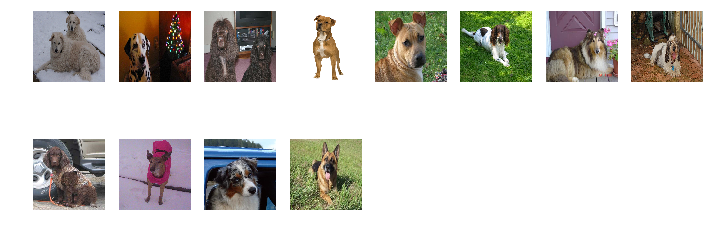

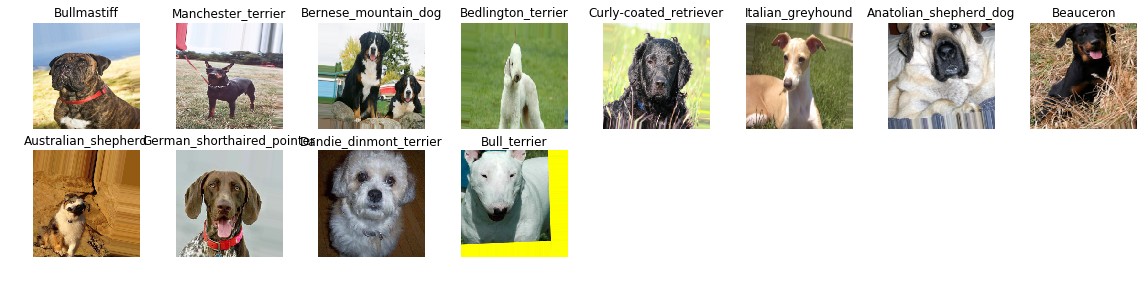

In [144]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50, preprocess_input
import math
import pandas as pd

def dog_name_formatter(name) :
    name = str(name)
    return name.split('.')[1]

def get_mutts(predicted_vector, mutt_threshold = 0.2) :
    predicted_vector = predicted_vector[0]
    predicted_vector_df = pd.DataFrame(data=predicted_vector, columns=['probability'])
    predicted_vector_df['index'] = range(0, len(predicted_vector_df))

    predicted_vector_df = predicted_vector_df.sort_values(['probability'], ascending=[False])
    predicted_vector_df = predicted_vector_df.reset_index(drop=True)
    predicted_vector_df_high_probabilities = predicted_vector_df[predicted_vector_df['probability'] >= mutt_threshold]
    breed_names = []
    if(len(predicted_vector_df_high_probabilities.index) > 1) :
        breed_names = np.array(dog_names)[predicted_vector_df_high_probabilities['index']]
    else :
        total_probability = 0
        count = 0
        while total_probability < mutt_threshold :
            total_probability += predicted_vector_df.iloc[count]['probability']
            count += 1
        breed_names = np.array(dog_names)[predicted_vector_df['index'].head(count)]
        
    
    return np.array(list(map(dog_name_formatter, breed_names)))


def get_data_augmentation_generators(batch_size = 20, preprocess_input_function = None, save_to_dir=None) :
    #instead of using fit, use flow_from_directory: better speed instead of repetitive datagen calls & better refactoring
    # create and configure augmented image generator
    augmentation_datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        rescale=1./255,
        horizontal_flip=True)

    train_generator = augmentation_datagen.flow_from_directory(
            'data/dog_images/train',
            target_size=(224, 224),
            batch_size=batch_size,
            class_mode='categorical')
    number_of_train_samples = len(train_generator.filenames)
    number_of_train_steps = int(math.ceil(number_of_train_samples / float(batch_size)))



    valid_generator = augmentation_datagen.flow_from_directory(
            'data/dog_images/valid',
            target_size=(224, 224),
            batch_size=batch_size,
            class_mode='categorical')
    number_of_valid_samples = len(valid_generator.filenames)
    number_of_valid_steps = int(math.ceil(number_of_valid_samples / float(batch_size)))
    
    count = 0
    plt.figure(figsize=(12, 9))
    for tensor in train_tensors :
        plt.subplot(4, 8, count+1)
        plt.imshow(tensor)
        plt.axis('off')
        count +=1
        if count == 12 :
            break

    x_batch, y_batch = next(train_generator)

    plt.figure(figsize=(20, 9))

    count=0

    for augmented_tensor in x_batch :
        plt.subplot(4, 8, count+1)
        text_label = get_mutts([y_batch[count]])[0]
        plt.title(text_label)
        plt.imshow(augmented_tensor.astype('float32'))
        plt.axis('off')
        #display(get_mutts(y_batch[count]))
        count +=1
        if count == 12 :
            break

    
    return train_generator, number_of_train_steps, valid_generator, number_of_valid_steps

train_generator, number_of_train_steps, valid_generator, number_of_valid_steps = get_data_augmentation_generators()


In [50]:
from keras.callbacks import ModelCheckpoint   

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                                   verbose=1, save_best_only=True)


model.fit_generator(train_generator,
                    steps_per_epoch=number_of_train_steps,
                    epochs=20, verbose=2, callbacks=[checkpointer],
                    validation_data=valid_generator,
                    validation_steps=number_of_valid_steps,
                    use_multiprocessing=True,
                    workers=10)



Epoch 1/20


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


 - 32s - loss: 1.8965 - acc: 0.6060 - val_loss: 4.9877 - val_acc: 0.0429

Epoch 00001: val_loss improved from inf to 4.98768, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/20
 - 32s - loss: 1.9399 - acc: 0.6180 - val_loss: 5.6663 - val_acc: 0.0190

Epoch 00002: val_loss did not improve from 4.98768
Epoch 3/20
 - 31s - loss: 1.9704 - acc: 0.5970 - val_loss: 4.6276 - val_acc: 0.0488

Epoch 00003: val_loss improved from 4.98768 to 4.62762, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 4/20
 - 30s - loss: 2.6273 - acc: 0.4376 - val_loss: 6.0627 - val_acc: 0.0821

Epoch 00004: val_loss did not improve from 4.62762
Epoch 5/20
 - 31s - loss: 2.6694 - acc: 0.4322 - val_loss: 6.6301 - val_acc: 0.0786

Epoch 00005: val_loss did not improve from 4.62762
Epoch 6/20
 - 29s - loss: 2.6644 - acc: 0.4395 - val_loss: 4.2390 - val_acc: 0.1000

Epoch 00006: val_loss improved from 4.62762 to 4.23901, saving model to saved_models/weights.best.from_scratch.hdf5
Epoc

### Load the Model with the Best Validation Loss

In [51]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [52]:
# get index of predicted dog breed for each image in test set
predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 5.6220%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [53]:
bottleneck_features = np.load('data/bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [30]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [31]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [32]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint   
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, 
            train_targets, 
            validation_data=(valid_VGG16, valid_targets),
            epochs=20, 
            batch_size=20, 
            callbacks=[checkpointer], 
            verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 249us/step - loss: 12.7151 - acc: 0.1055 - val_loss: 11.4956 - val_acc: 0.1725

Epoch 00001: val_loss improved from inf to 11.49564, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 2/20
6680/6680 [==============================] - 1s 158us/step - loss: 10.7389 - acc: 0.2455 - val_loss: 10.9082 - val_acc: 0.2228

Epoch 00002: val_loss improved from 11.49564 to 10.90825, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 3/20
6680/6680 [==============================] - 1s 158us/step - loss: 10.1491 - acc: 0.3100 - val_loss: 10.5720 - val_acc: 0.2419

Epoch 00003: val_loss improved from 10.90825 to 10.57198, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 4/20
6680/6680 [==============================] - 1s 158us/step - loss: 9.9167 - acc: 0.3367 - val_loss: 10.4750 - val_acc: 0.2707

Epoch 00004: val_loss improved from 10.57198 to 10.47497, saving model

### Load the Model with the Best Validation Loss

In [33]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [34]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 43.1818%


### Predict Dog Breed with the Model

In [35]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return get_mutts(predicted_vector)

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras.  These are already in the workspace, at /data/bottleneck_features.  If you wish to download them on a different machine, they can be found at:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  

The above architectures are downloaded and stored for you in the `/data/bottleneck_features/` folder.

This means the following will be in the `/data/bottleneck_features/` folder:

`DogVGG19Data.npz`
`DogResnet50Data.npz`
`DogInceptionV3Data.npz`
`DogXceptionData.npz`



### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('/data/bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [102]:
from keras.applications.resnet50 import ResNet50
resnet_pretrained_model = ResNet50(weights='imagenet', include_top=False)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [55]:
from keras.applications.xception import Xception
xception_pretrained_model = Xception(weights='imagenet', include_top=False)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

**I ran into this issue when using resnet50: https://github.com/keras-team/keras/issues/9214** I therefore opted to change my models to use xception

I initially added a global pooling layer. This is often done in these transfer learning examples and in most computer vision examples including resnet50 / xception (before it's dense layers). This pooling layer takes the resnet50 output layer's tensor shape as an input as this is what is fed as inputs into this model. 

I've added a number of fully connected denser layers as most of the heavy lifting is done in the resnet model and due to my limited computational power, I didn't want to make the model more advanced but believed I should focus on image augmentation due to the small data set size.

I've added dropout as before to prevent dead neurons during backpropagation. Dropout means that there is a 20% probability of a neuron being switched off during training - this means that during training, data is more likely to traverse all neurons in the network, making back propagation more effective. 

I've used a relu activation function to increase the non-linearity whilst maintaing performace.

133 output nodes as there are 1333 dog categories. the softmax function is used to give us probabilistic outcomes across multiple classes from a single value which fits the problem.



In [56]:
#bottleneck_features = np.load('data/bottleneck_features/DogResnet50Data.npz')
#train_resnet = bottleneck_features['train']
#valid_resnet = bottleneck_features['valid']
#test_resnet = bottleneck_features['test']

In [103]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.models import Model


def final_model_layers(base_model) :
    x = base_model.output
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dropout(0.2)(x)
    x = Dense(133, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(133, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(133, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(133, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(133, activation='relu')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(133, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
   
    # transfer learning
    for layer in base_model.layers:
        layer.trainable = False
    base_model.trainable = False
    return model


#resnet_model = final_model_layers(resnet_pretrained_model)
#resnet_model_with_augmentation = final_model_layers(resnet_pretrained_model)
xception_model = final_model_layers(xception_pretrained_model)
xception_model_with_augmentation = final_model_layers(xception_pretrained_model)
resnet_model = final_model_layers(resnet_pretrained_model)
#resnet_model.summary()
#resnet_model_with_augmentation.summary()
xception_model.summary()
xception_model_with_augmentation.summary()
resnet_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

### (IMPLEMENTATION) Compile the Model

In [104]:
### TODO: Compile the model.
resnet_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#resnet_model_with_augmentation.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
xception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
xception_model_with_augmentation.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [59]:
from keras.callbacks import ModelCheckpoint   
'''resnet_checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.resnet.hdf5', 
                               verbose=1, save_best_only=True)

resnet_model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=5, callbacks=[resnet_checkpointer], verbose=1)
resnet_with_augmentation_checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.resnet_augmented.hdf5', 
                               verbose=1, save_best_only=True)

resnet_model_with_augmentation.fit_generator(train_generator,
          validation_data=valid_generator,
          validation_steps = number_of_valid_steps,
          steps_per_epoch=number_of_train_steps,
          epochs=5, callbacks=[resnet_with_augmentation_checkpointer], verbose=1)
'''
xception_checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.xception.hdf5', 
                               verbose=1, save_best_only=True)

xception_model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=50, callbacks=[xception_checkpointer], verbose=1)

xception_with_augmentation_checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.xception_with_augmentation.hdf5', 
                               verbose=1, save_best_only=True)

xception_model_with_augmentation.fit_generator(train_generator,
            validation_data=valid_generator,
            validation_steps = number_of_valid_steps,
            steps_per_epoch=number_of_train_steps,
            epochs=50, 
            callbacks=[xception_with_augmentation_checkpointer],
            verbose=1,                        
            use_multiprocessing=True,
            workers=10)





Train on 6680 samples, validate on 835 samples
Epoch 1/50
6680/6680 [==============================] - 16s 2ms/step - loss: 4.6222 - acc: 0.0344 - val_loss: 3.3384 - val_acc: 0.1844

Epoch 00001: val_loss improved from inf to 3.33840, saving model to saved_models/weights.best.xception.hdf5
Epoch 2/50
6680/6680 [==============================] - 12s 2ms/step - loss: 3.4037 - acc: 0.1754 - val_loss: 2.0208 - val_acc: 0.4347

Epoch 00002: val_loss improved from 3.33840 to 2.02077, saving model to saved_models/weights.best.xception.hdf5
Epoch 3/50
6680/6680 [==============================] - 13s 2ms/step - loss: 2.6558 - acc: 0.2915 - val_loss: 1.5437 - val_acc: 0.5593

Epoch 00003: val_loss improved from 2.02077 to 1.54374, saving model to saved_models/weights.best.xception.hdf5
Epoch 4/50
6680/6680 [==============================] - 13s 2ms/step - loss: 2.2473 - acc: 0.3734 - val_loss: 1.3614 - val_acc: 0.6180

Epoch 00004: val_loss improved from 1.54374 to 1.36137, saving model to saved

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


334/334 [==============================] - 35s 106ms/step - loss: 4.2616 - acc: 0.0934 - val_loss: 4.2129 - val_acc: 0.1000

Epoch 00001: val_loss improved from inf to 4.21290, saving model to saved_models/weights.best.xception_with_augmentation.hdf5
Epoch 2/50
334/334 [==============================] - 32s 96ms/step - loss: 3.5240 - acc: 0.2253 - val_loss: 4.6873 - val_acc: 0.2036

Epoch 00002: val_loss did not improve from 4.21290
Epoch 3/50
334/334 [==============================] - 31s 94ms/step - loss: 3.1719 - acc: 0.2756 - val_loss: 3.4264 - val_acc: 0.2226

Epoch 00003: val_loss improved from 4.21290 to 3.42640, saving model to saved_models/weights.best.xception_with_augmentation.hdf5
Epoch 4/50
334/334 [==============================] - 29s 88ms/step - loss: 2.5723 - acc: 0.3734 - val_loss: 3.9906 - val_acc: 0.3119

Epoch 00004: val_loss did not improve from 3.42640
Epoch 5/50
334/334 [==============================] - 30s 90ms/step - loss: 2.4257 - acc: 0.4079 - val_loss: 3.4


Epoch 00040: val_loss did not improve from 1.45237
Epoch 41/50
334/334 [==============================] - 31s 93ms/step - loss: 1.3913 - acc: 0.6576 - val_loss: 2.0550 - val_acc: 0.7134

Epoch 00041: val_loss did not improve from 1.45237
Epoch 42/50
334/334 [==============================] - 31s 93ms/step - loss: 1.4857 - acc: 0.6340 - val_loss: 1.8968 - val_acc: 0.7143

Epoch 00042: val_loss did not improve from 1.45237
Epoch 43/50
334/334 [==============================] - 31s 94ms/step - loss: 1.4730 - acc: 0.6427 - val_loss: 1.6912 - val_acc: 0.7381

Epoch 00043: val_loss did not improve from 1.45237
Epoch 44/50
334/334 [==============================] - 31s 93ms/step - loss: 1.4433 - acc: 0.6386 - val_loss: 1.8812 - val_acc: 0.6976

Epoch 00044: val_loss did not improve from 1.45237
Epoch 45/50
334/334 [==============================] - 30s 90ms/step - loss: 1.3828 - acc: 0.6656 - val_loss: 2.1618 - val_acc: 0.6560

Epoch 00045: val_loss did not improve from 1.45237
Epoch 46/50
3

In [106]:
resnet_checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.resnet.hdf5', 
                               verbose=1, save_best_only=True)

resnet_model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=20, callbacks=[resnet_checkpointer], verbose=1)


Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 11s 2ms/step - loss: 4.0752 - acc: 0.0597 - val_loss: 5.1236 - val_acc: 0.0084

Epoch 00001: val_loss improved from inf to 5.12355, saving model to saved_models/weights.best.resnet.hdf5
Epoch 2/20
6680/6680 [==============================] - 11s 2ms/step - loss: 3.4259 - acc: 0.1253 - val_loss: 5.0840 - val_acc: 0.0084

Epoch 00002: val_loss improved from 5.12355 to 5.08402, saving model to saved_models/weights.best.resnet.hdf5
Epoch 3/20
6680/6680 [==============================] - 11s 2ms/step - loss: 2.9477 - acc: 0.1958 - val_loss: 5.4559 - val_acc: 0.0096

Epoch 00003: val_loss did not improve from 5.08402
Epoch 4/20
6680/6680 [==============================] - 11s 2ms/step - loss: 2.7243 - acc: 0.2424 - val_loss: 5.2426 - val_acc: 0.0096

Epoch 00004: val_loss did not improve from 5.08402
Epoch 5/20
6680/6680 [==============================] - 11s 2ms/step - loss: 2.4816 - acc: 

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [155]:
### TODO: Load the model weights with the best validation loss.
#resnet_model.load_weights('saved_models/weights.best.resnet.hdf5')
#resnet_model_with_augmentation.load_weights('saved_models/weights.best.resnet_augmented.hdf5')
xception_model.load_weights('saved_models/weights.best.xception.hdf5')
xception_model_with_augmentation.load_weights('saved_models/weights.best.xception_with_augmentation.hdf5')
resnet_model.load_weights('saved_models/weights.best.resnet.hdf5')


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [169]:

def make_predictions(model) :
    pred = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test_tensors]

    # report test accuracy
    test_accuracy = 100*np.sum(np.array(pred)==np.argmax(test_targets, axis=1))/len(pred)
    print('Test accuracy: %.4f%%' % test_accuracy)


#make_predictions(resnet_model)
#make_predictions(resnet_model_with_augmentation)
make_predictions(xception_model)
make_predictions(xception_model_with_augmentation)
make_predictions(resnet_model)

Test accuracy: 70.2153%
Test accuracy: 72.2488%
Test accuracy: 0.7177%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [141]:
def xception_predict_breed(img_path):
    from keras.applications.xception import preprocess_input

    # extract bottleneck features
    input_tensor = path_to_tensor(img_path)
    input_tensor.astype('float32')/255
    # obtain predicted vector
    predicted_vector = xception_model.predict(preprocess_input(input_tensor))
    # return dog breed that is predicted by the model
    
    return get_mutts(predicted_vector)

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [142]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
def final_predictor(img_path) :
    print('calling final predictor')
    is_human = face_detector(img_path)
    is_dog = dog_detector(img_path)
    if(not is_human and not is_dog) :
        raise Exception('This Image contains neither a dog nor a human!') 
    
    return is_human, xception_predict_breed(img_path)

def display_final_prediction(is_human, dog_breeds, img_path) :

    if(is_human):
        print("Hello human!")
    else :
        print("Hello doggo!")

    img = cv2.imread(img_path,cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(img_rgb)
    plt.show()
    print("You look like a....")
    breed_list = ', '.join(map(str, dog_breeds)) 
    if(len(dog_breeds) > 1) :
        print("mutt: %s" % breed_list)
    else :
        print("pure-bred: %s" % breed_list)

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 
* Overall I am happy with the output from the model considering the little amount of effort and resource required to get it to where it is now.
* focus more on reading mix-breeds... both mix breed dogs are classified incorrectly
* work through more hyper-parameter variations on a machine with a better GPU in order to find out better combinations of convolutional layers.
* Perform more data augmentation to reduce the chances of overfitting
* increase the original data set size (it is a small data set)

loading file  test_images/labradoodle.jpeg
calling final predictor
calling path to tensor to load image to array
calling path to tensor to load image to array
Hello doggo!


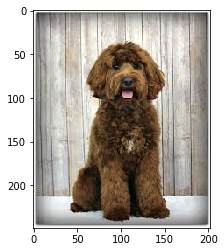

You look like a....
mutt: Portuguese_water_dog, Wirehaired_pointing_griffon
loading file  test_images/husky-pomeranian.jpg
calling final predictor
calling path to tensor to load image to array
calling path to tensor to load image to array
Hello doggo!


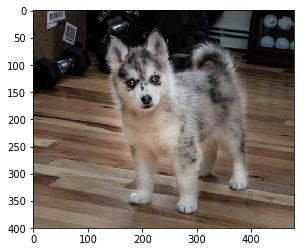

You look like a....
pure-bred: Alaskan_malamute
loading file  test_images/Golden_retriever_05181.jpg
calling final predictor
calling path to tensor to load image to array
calling path to tensor to load image to array
Hello human!


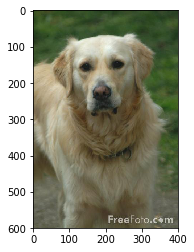

You look like a....
pure-bred: Golden_retriever
loading file  test_images/martine.jpg
calling final predictor
calling path to tensor to load image to array
calling path to tensor to load image to array
Hello human!


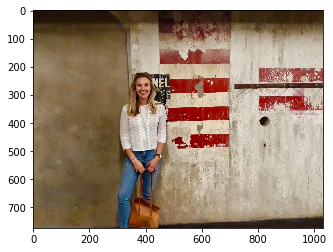

You look like a....
mutt: German_shorthaired_pointer, Pointer, Plott, Cane_corso
loading file  test_images/golden-retriever.jpg
calling final predictor
calling path to tensor to load image to array
calling path to tensor to load image to array
Hello doggo!


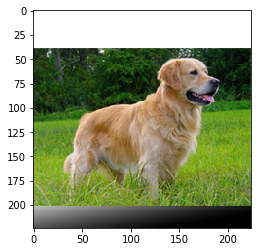

You look like a....
pure-bred: Golden_retriever
loading file  test_images/basset-hound.jpg
calling final predictor
calling path to tensor to load image to array
calling path to tensor to load image to array
Hello doggo!


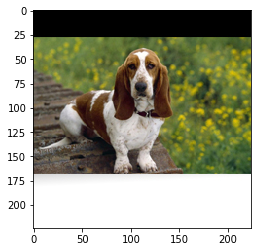

You look like a....
pure-bred: Basset_hound
loading file  test_images/bird-2.jpg
calling final predictor
calling path to tensor to load image to array
calling path to tensor to load image to array
Hello human!


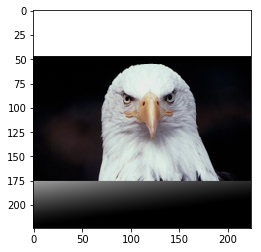

You look like a....
mutt: Bichon_frise, Chihuahua, Parson_russell_terrier, French_bulldog, Boston_terrier, Havanese, Bulldog, Smooth_fox_terrier, Old_english_sheepdog
loading file  test_images/bird-1.jpg
calling final predictor
calling path to tensor to load image to array
This Image contains neither a dog nor a human!
loading file  test_images/me.jpg
calling final predictor
calling path to tensor to load image to array
calling path to tensor to load image to array
Hello human!


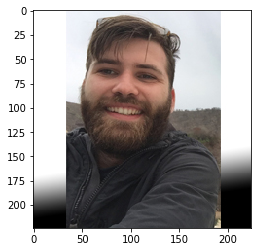

You look like a....
mutt: Great_dane, American_staffordshire_terrier, German_pinscher, Australian_cattle_dog, Cane_corso, Giant_schnauzer, Pointer, Kerry_blue_terrier, Glen_of_imaal_terrier, Doberman_pinscher, German_wirehaired_pointer


In [145]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
import os

def load_directory_files(path) :
    filelist=os.listdir(path)
    for file in filelist[:]: # filelist[:] makes a copy of filelist.
        if(not file.endswith(".jpg") and not file.endswith('.jpeg') and not file.enswith('.png')):
            filelist.remove(file)
    return filelist


base_path = 'test_images/'
for file in load_directory_files(base_path) :
    try :
        print("loading file ",base_path + file)
        is_human, dog_breed = final_predictor(base_path + file)
        display_final_prediction(is_human, dog_breed, base_path + file)
    except Exception as e:
        if hasattr(e, 'message'):
            print(e.message)
        else:
            print(e)


In [1]:
import os
import numpy as np
import pandas as pd
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle


FTRAIN = 'data/facial_landmarks/training.csv'
FTEST = 'data/facial_landmarks/test.csv'


def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe
    
    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]
        
    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    images = df['Image'].str.split().values
    df['Image'] = [ np.split(np.array(image).astype('float32') / 255 ,96) for image in images]

    df = df.dropna()  # drop all rows that have missing values in them
   
    X = np.array(df['Image'].values)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None
        
    return X, y


In [2]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline      

def plot_sample(img, y, axis):
    print(np.array(img).shape)
    axis.imshow(img, cmap='gray')
    if(len(y) > 0) :
        axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)




In [72]:
X, y = load(test=False)


(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


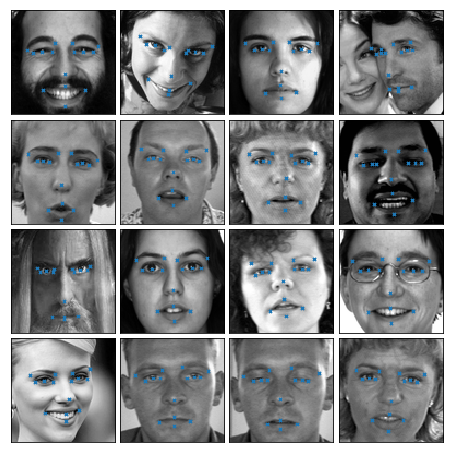

In [74]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X[i], y[i], ax)

plt.show()


In [75]:
X_test, _ = load(test=True)


(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


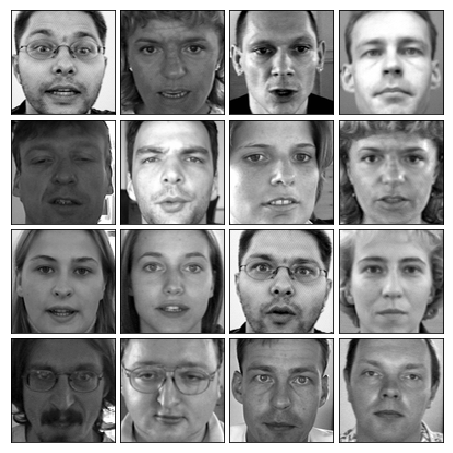

In [76]:

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X_test[i], [], ax)

plt.show()


In [27]:
def load2d(test=False, cols=None):
    X, y = load(test=test, cols=cols)
    X = np.stack(X)[:, :, :, np.newaxis]
    if y is np.ndarray :
        y = np.vstack(y)

    return X, y



In [31]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.models import Sequential

def create_facial_model() :
    model = Sequential()
    model.add(Dense(100, activation="relu", input_shape=(96*96,)))
    model.add(Activation('relu'))
    model.add(Dense(4))


    model.summary()
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
    
    return model




In [32]:

mouth_feature_model = create_facial_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               921700    
_________________________________________________________________
activation_3 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 404       
Total params: 922,104
Trainable params: 922,104
Non-trainable params: 0
_________________________________________________________________


In [28]:
training_tensors, training_labels = load2d(cols=['mouth_left_corner_x','mouth_left_corner_y','mouth_right_corner_x','mouth_right_corner_y'])


In [34]:
from keras import optimizers
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.facial_landmarks.hdf5', 
                                   verbose=1, save_best_only=True,)

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
mouth_feature_model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
epochs = 200
history = mouth_feature_model.fit(training_tensors.reshape(training_labels.shape[0], -1), training_labels, 
                 validation_split=0.2, shuffle=True, 
                callbacks=[checkpointer],
                 epochs=epochs, batch_size=20)

(2263, 4)
Train on 1810 samples, validate on 453 samples
Epoch 1/200
1810/1810 [==============================] - 1s 724us/step - loss: 0.7774 - acc: 0.4514 - val_loss: 0.0127 - val_acc: 0.5011

Epoch 00001: val_loss improved from inf to 0.01274, saving model to saved_models/weights.best.facial_landmarks.hdf5
Epoch 2/200
1810/1810 [==============================] - 0s 118us/step - loss: 0.0119 - acc: 0.4768 - val_loss: 0.0108 - val_acc: 0.5408

Epoch 00002: val_loss improved from 0.01274 to 0.01079, saving model to saved_models/weights.best.facial_landmarks.hdf5
Epoch 3/200
1810/1810 [==============================] - 0s 119us/step - loss: 0.0095 - acc: 0.4967 - val_loss: 0.0093 - val_acc: 0.5011

Epoch 00003: val_loss improved from 0.01079 to 0.00928, saving model to saved_models/weights.best.facial_landmarks.hdf5
Epoch 4/200
1810/1810 [==============================] - 0s 120us/step - loss: 0.0084 - acc: 0.5055 - val_loss: 0.0094 - val_acc: 0.5585

Epoch 00004: val_loss did not impro


Epoch 00037: val_loss improved from 0.00575 to 0.00575, saving model to saved_models/weights.best.facial_landmarks.hdf5
Epoch 38/200
1810/1810 [==============================] - 0s 118us/step - loss: 0.0039 - acc: 0.6956 - val_loss: 0.0062 - val_acc: 0.7196

Epoch 00038: val_loss did not improve from 0.00575
Epoch 39/200
1810/1810 [==============================] - 0s 118us/step - loss: 0.0038 - acc: 0.7055 - val_loss: 0.0059 - val_acc: 0.6887

Epoch 00039: val_loss did not improve from 0.00575
Epoch 40/200
1810/1810 [==============================] - 0s 118us/step - loss: 0.0037 - acc: 0.7072 - val_loss: 0.0057 - val_acc: 0.7196

Epoch 00040: val_loss improved from 0.00575 to 0.00568, saving model to saved_models/weights.best.facial_landmarks.hdf5
Epoch 41/200
1810/1810 [==============================] - 0s 118us/step - loss: 0.0037 - acc: 0.7061 - val_loss: 0.0060 - val_acc: 0.7086

Epoch 00041: val_loss did not improve from 0.00568
Epoch 42/200
1810/1810 [==========================

1810/1810 [==============================] - 0s 118us/step - loss: 0.0030 - acc: 0.7276 - val_loss: 0.0057 - val_acc: 0.6689

Epoch 00079: val_loss did not improve from 0.00523
Epoch 80/200
1810/1810 [==============================] - 0s 118us/step - loss: 0.0030 - acc: 0.7293 - val_loss: 0.0052 - val_acc: 0.7152

Epoch 00080: val_loss did not improve from 0.00523
Epoch 81/200
1810/1810 [==============================] - 0s 117us/step - loss: 0.0029 - acc: 0.7331 - val_loss: 0.0053 - val_acc: 0.6887

Epoch 00081: val_loss did not improve from 0.00523
Epoch 82/200
1810/1810 [==============================] - 0s 117us/step - loss: 0.0029 - acc: 0.7271 - val_loss: 0.0056 - val_acc: 0.7174

Epoch 00082: val_loss did not improve from 0.00523
Epoch 83/200
1810/1810 [==============================] - 0s 118us/step - loss: 0.0029 - acc: 0.7276 - val_loss: 0.0054 - val_acc: 0.7263

Epoch 00083: val_loss did not improve from 0.00523
Epoch 84/200
1810/1810 [==============================] - 0s 11


Epoch 00121: val_loss did not improve from 0.00515
Epoch 122/200
1810/1810 [==============================] - 0s 120us/step - loss: 0.0026 - acc: 0.7210 - val_loss: 0.0054 - val_acc: 0.6689

Epoch 00122: val_loss did not improve from 0.00515
Epoch 123/200
1810/1810 [==============================] - 0s 119us/step - loss: 0.0025 - acc: 0.7315 - val_loss: 0.0053 - val_acc: 0.6865

Epoch 00123: val_loss did not improve from 0.00515
Epoch 124/200
1810/1810 [==============================] - 0s 120us/step - loss: 0.0025 - acc: 0.7282 - val_loss: 0.0058 - val_acc: 0.6446

Epoch 00124: val_loss did not improve from 0.00515
Epoch 125/200
1810/1810 [==============================] - 0s 120us/step - loss: 0.0024 - acc: 0.7238 - val_loss: 0.0052 - val_acc: 0.6799

Epoch 00125: val_loss did not improve from 0.00515
Epoch 126/200
1810/1810 [==============================] - 0s 120us/step - loss: 0.0025 - acc: 0.7337 - val_loss: 0.0053 - val_acc: 0.6887

Epoch 00126: val_loss did not improve from 0

1810/1810 [==============================] - 0s 119us/step - loss: 0.0021 - acc: 0.7315 - val_loss: 0.0052 - val_acc: 0.6976

Epoch 00164: val_loss did not improve from 0.00512
Epoch 165/200
1810/1810 [==============================] - 0s 120us/step - loss: 0.0020 - acc: 0.7304 - val_loss: 0.0054 - val_acc: 0.6998

Epoch 00165: val_loss did not improve from 0.00512
Epoch 166/200
1810/1810 [==============================] - 0s 120us/step - loss: 0.0020 - acc: 0.7381 - val_loss: 0.0057 - val_acc: 0.7130

Epoch 00166: val_loss did not improve from 0.00512
Epoch 167/200
1810/1810 [==============================] - 0s 120us/step - loss: 0.0020 - acc: 0.7459 - val_loss: 0.0057 - val_acc: 0.7064

Epoch 00167: val_loss did not improve from 0.00512
Epoch 168/200
1810/1810 [==============================] - 0s 120us/step - loss: 0.0020 - acc: 0.7315 - val_loss: 0.0051 - val_acc: 0.7020

Epoch 00168: val_loss did not improve from 0.00512
Epoch 169/200
1810/1810 [==============================] - 

In [35]:
mouth_feature_model.load_weights('saved_models/weights.best.facial_landmarks.hdf5')

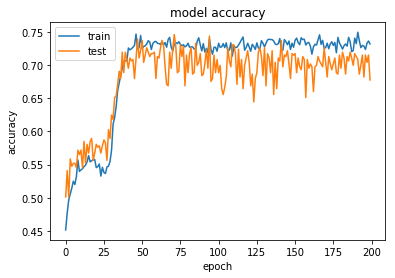

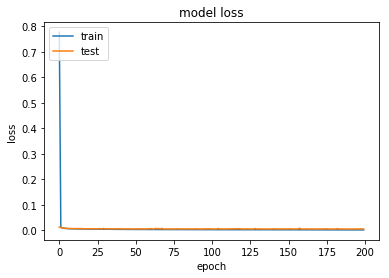

In [36]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
test_tensors, test_labels = load2d(test=True)


In [38]:
test_results = [ mouth_feature_model.predict(test_tensor.reshape(1,-1)) for test_tensor in test_tensors]



In [39]:
test_images, _ = load(test=True)


(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


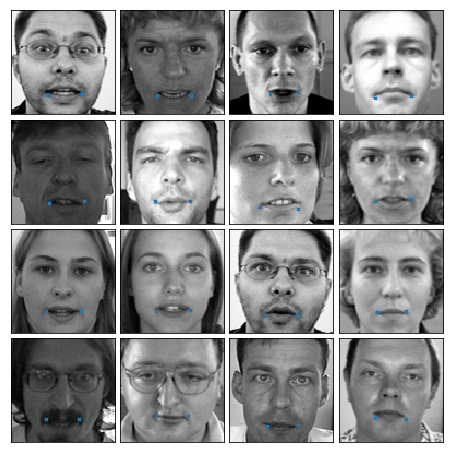

In [40]:

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(test_images[i], test_results[i][0], ax)

plt.show()

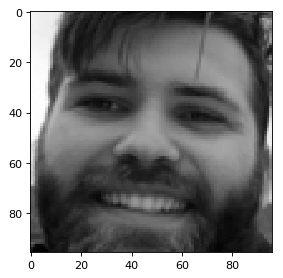

(96, 96)


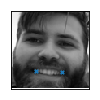

<Figure size 480x320 with 0 Axes>

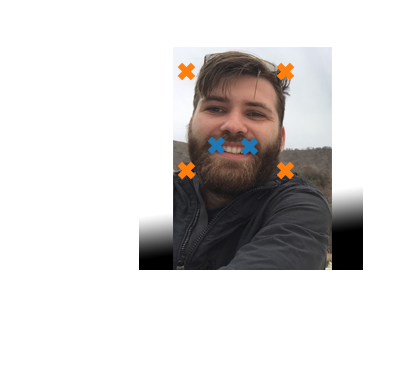

In [73]:
import matplotlib as mpl

def face_detection_and_transform_pipeline(img_path) :
    mpl.rcParams['figure.dpi']= 80
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    

    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        res_roi_gray = cv2.resize(roi_gray, dsize=(96, 96), interpolation=cv2.INTER_LINEAR) / 255
        height, width = res_roi_gray.shape
        
        plt.imshow(res_roi_gray, cmap='gray')
        plt.show()
        
        landmarks = mouth_feature_model.predict(res_roi_gray.reshape(1,-1))

        fig = plt.figure()
        fig.subplots_adjust(
            left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        plot_sample(res_roi_gray, landmarks[0], ax)
        plt.show()

        
        plt.clf()
        
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        dpi = 300
        mpl.rcParams['figure.dpi']= dpi
        height, width, depth = img_rgb.shape
        scale_width = width / float(dpi)
        scale_height = height / float(dpi)
        
        landmarks[0][0] = ((landmarks[0][0] * 48) + 48) + x
        landmarks[0][1] =  ((landmarks[0][1] * 48) + 48) + y
        
        landmarks[0][2] = ((landmarks[0][2] * 48) + 48) + x
        landmarks[0][3] = ((landmarks[0][3] * 48) + 48) + y

        # What size does the figure need to be in inches to fit the image?
        figsize = scale_width, scale_height

        # Create a figure of the right size with one axes that takes up the full figure
        fig = plt.figure(figsize=figsize)
        ax = fig.add_axes([0, 0, 1, 1])
        ax.scatter(landmarks[0][0::2], landmarks[0][1::2], marker='x', s=10)
        ax.scatter([x, x+ h, x,x+w], [y, y,y+h,y+h], marker='x', s=10)

        
        # Hide spines, ticks, etc.
        ax.axis('off')

        # Display the image.
        ax.imshow(img_rgb)

        plt.show()
        

        
test_img = '/home/ubuntu/dog-breed-cnn-classifier/test_images/me.jpg'
face_detection_and_transform_pipeline(test_img)